# Poker Parser

- luck: number won at showdown
- get lifetime versions of all graphs
- which round they went out onwhen they didn't win a hand, plot using bar_plotter
- for each player, pie chart of how they exited each hand, fold, lost showdown, won showdown

## Import functions

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import winnings_analysis, rounds_analysis
from datetime import datetime

In [2]:
date = '11_03_21'
if date=='auto':
    date = datetime.now().strftime("%d_%m_%y")

## Load and process data

In [3]:
dfraw = pd.read_csv(f'../data/sheff_crew/data_{date}.csv').reset_index(drop=True)

names = winnings_analysis.get_names(dfraw)
df = winnings_analysis.get_totals(dfraw, names)

In [4]:
fig_folder = '../figures/' + date
if not os.path.exists(fig_folder):
    os.mkdir(fig_folder)

## Colour tester

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)] 



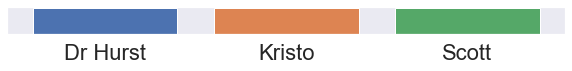

In [12]:
randomise = False

from matplotlib import colors as mcolors
cols = list(mcolors.CSS4_COLORS.keys())
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
cols = [c for c in cols if 'white' not in c]

if randomise:
    np.random.shuffle(cols)

plt.figure(figsize=[10,0.5])
for i,n in enumerate(names):
    plt.bar([names[i]], [1], color=cols[i])
    plt.xticks(rotation=0);
    plt.yticks([]);
print(cols[:len(names)], '\n')

# Some good colour schemes
# cols = ['mediumturquoise', 'grey', 'red', 'darkmagenta']
# cols = ['forestgreen', 'orange', 'purple', 'cornflowerblue']
# cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise','grey']

## Total bankroll over time

In [16]:
def plot_bankroll(df_totals, names, savepath=None):
    plt.figure(figsize=[15,10])
    sns.set(font_scale=2)
    for i,n in enumerate(names):
        plt.plot(np.arange(1,len(df_totals)+1),df_totals[n].values,label=n,color=cols[i],linewidth=4)
    plt.legend()
    plt.xlabel('Round number')
    plt.ylabel('£££')
    plt.xlim(left=0);
    plt.gca().axhline(0,dashes=[3,6],linewidth=.5,color='black')
    plt.gca().axhline(df.loc[0,names[0]],dashes=[3,6],linewidth=.5,color='black')

    if savepath is not None:
        plt.savefig(savepath,bbox_inches='tight')

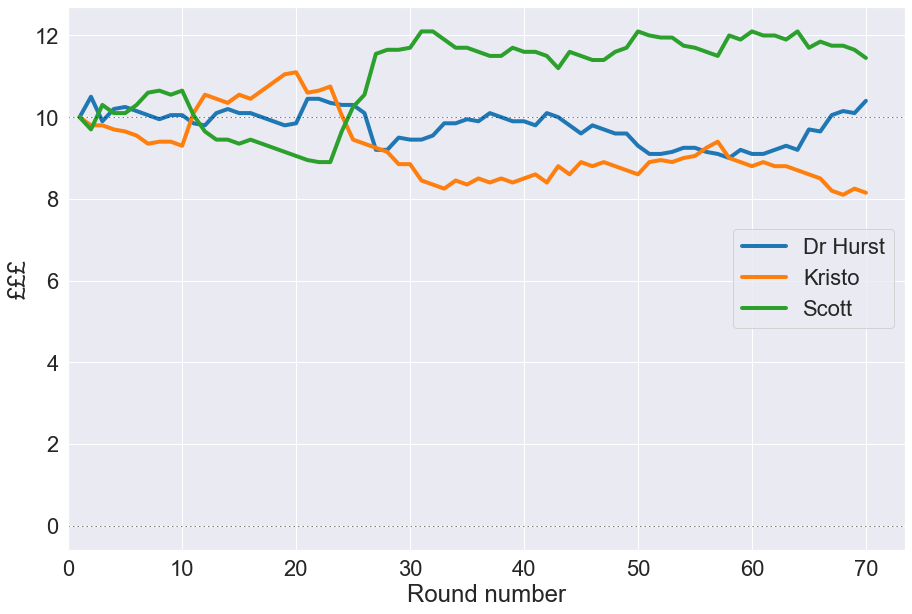

In [8]:
plot_bankroll(df, names, os.path.join(fig_folder, 'bankroll.png'))

In [9]:
df

,Dr Hurst,Kristo,Scott,time
0,10.00,10.00,10.00,0.00
1,10.50,9.80,9.70,0.00
2,9.90,9.80,10.30,1.66
3,10.20,9.70,10.10,3.05
4,10.25,9.65,10.10,4.10
...,...,...,...,...
65,9.65,8.50,11.85,82.37
66,10.05,8.20,11.75,84.05
67,10.15,8.10,11.75,85.45
68,10.10,8.25,11.65,86.53


## Winnings and losses per round

In [10]:
def plot_winnings(df, names, savepath=None):
    plt.figure(figsize=[15,10])
    sns.set(font_scale=2)

    previous = (np.arange(1,len(df))*0).astype(float)
    max_ = 0
    for i,n in enumerate(names):
        diffs = np.diff(df[n])

        above_part = np.where(diffs>0, diffs, 0)
        max_ = max(max_, max(above_part))
        plt.bar(np.arange(1,len(df)),above_part,color=cols[i], label=n, alpha=1)

        bottom_part = np.diff(df[n])
        bottom_part = np.where(diffs<0, -diffs, 0)
        previous-=bottom_part

        inds = np.where(bottom_part!=0)[0]
        y_plot = bottom_part[inds]
        x_plot = np.arange(1,len(df))[inds] 
        plt.bar(x_plot,y_plot,bottom=previous[inds],color=cols[i], alpha=1)


    plt.legend(loc=[0.02,.77])
    plt.xlabel('Round number')
    plt.ylabel('Winnings')

    plt.ylim((-max_*1.1,max_*1.1));
    
    if savepath is not None:
        plt.savefig(savepath,bbox_inches='tight')    

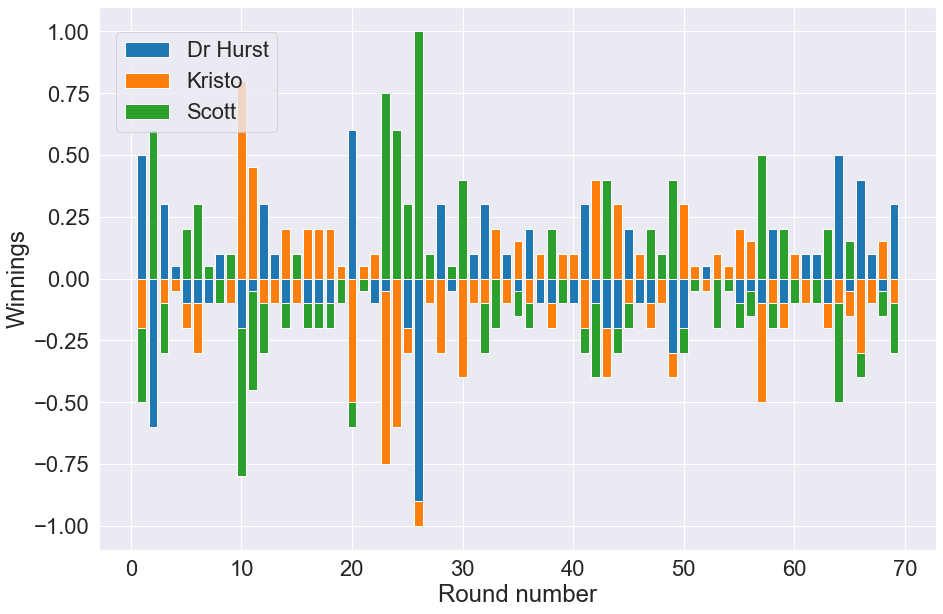

In [10]:
plot_winnings(df, names, os.path.join(fig_folder, 'winnings.png'))

## Who won at which parts?

In [11]:
win_on, win_on_perc = rounds_analysis.get_round_wins(dfraw, names)

In [88]:
def bar_plotter(df, save=True, fig_folder=None, ylabel='', filename=None, width=10):
    fig = plt.figure(figsize=(width,5))
    sns.set(font_scale=2)
    
    rounds = [c for c in df.columns if c!='Name']
    names = list(df['Name'].values)
    
    main_ticks = np.arange(len(rounds))
    jump = 1/(len(names)+1)
    
    for i, n in enumerate(names):
        xpos = main_ticks + jump*i
        
        data_to_plot = [df.loc[df['Name']==n, r].values[0] for r in rounds]
        
        plt.bar(
            xpos,
            data_to_plot,
            width=jump*0.9,
            label=n.title(),
            color=cols[i]
        )
        
    plt.ylabel(ylabel)
        
    plt.gca().set_xticks(main_ticks + jump*(i/2))
    plt.gca().set_xticklabels(rounds)
    legend = plt.legend(title='Player', loc=[0.55,0.3])
    plt.setp(legend.get_title(),fontsize=15)
    plt.grid(axis='x')
    if save:
        plt.savefig(os.path.join(fig_folder, filename),bbox_inches='tight')
    return

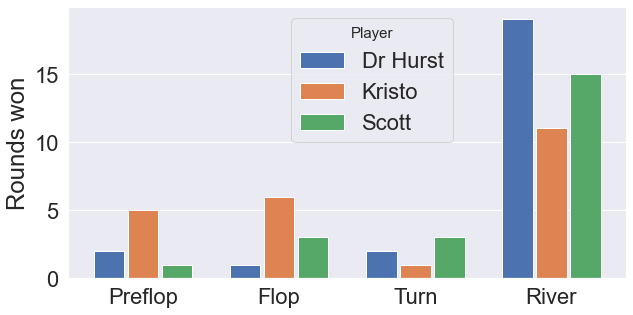

In [70]:
bar_plotter(win_on, save=True, ylabel='Rounds won', fig_folder=fig_folder, filename='absrounds.png')

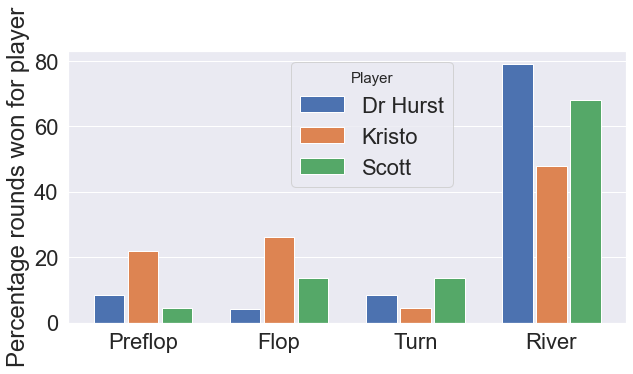

In [71]:
bar_plotter(win_on_perc, save=True, ylabel='Percentage rounds won for player', fig_folder=fig_folder, filename='percrounds.png')

## Which hands did people win with?

In [16]:
df_showdown = winnings_analysis.get_showdown_hands(dfraw, names)

In [28]:
def col_renamer(df_):
    df = df_.copy()
    df = df.rename(columns={
    'fold':'Others\nFolded',
    'high':'High\nCard',
    'pair':'Pair',
    'two pair':'Two\nPair',
    'three of a kind':'Three\nof a\nKind',
    'straight':'Straight',
    'flush':'Flush',
    'full house':'Full\nHouse',
    'four of a kind':'Four\nof a\nKind',
    'straight flush':'Straight\nFlush',
    'royal flush':'Royal\nFlush',
    })
    return df

In [ ]:
df_showdown = col_renamer(df_showdown)

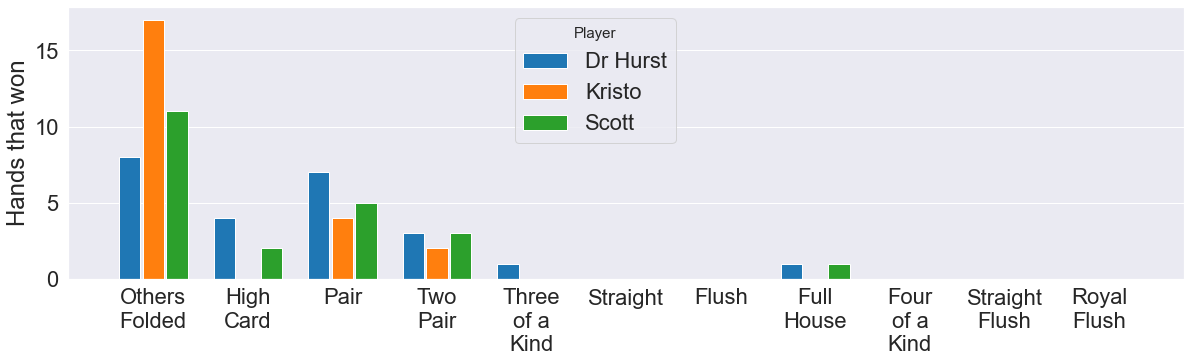

In [21]:
bar_plotter(df_showdown, save=True, fig_folder=fig_folder, ylabel='Hands that won', filename='showdown.png', width=20)

## Lifetime performance

In [5]:
#Get the datafiles

datalist = [f for f in os.listdir('../data/sheff_crew') if 'data' in f]

datalist = [x[5:-4] for x in datalist]
datalist = sorted(datalist, key = lambda x: datetime.strptime(x, '%d_%m_%y'))
datalist = ['data_'+x+'.csv' for x in datalist]

dfall = [pd.read_csv(f'../data/sheff_crew/{x}') for x in datalist]

In [6]:
# Get all available names. We should manually group these into a list of lists.

allnames = list(set([item for sublist in [winnings_analysis.get_names(d) for d in dfall] for item in sublist]))

namegroups = [
    ['Scott','Scottyboi','Dr Scott','Dr. Scott'],
    ['David','Dr Hurst','Dr. Hurst'],
    ['Kristo','kris','Kris','Also a DR','Krist','kristo'],
    ['Mike','Michael','Dr. Roche']
]

In [7]:
lifetimedf = winnings_analysis.get_lifetime_performance(dfall, namegroups)
lifetimenames = [n[0] for n in namegroups]

17/17


In [14]:
lifetimedf

,Scott,David,Kristo,Mike
0,0.00,0.00,0.00,0.00
1,-0.20,0.00,0.00,0.20
2,-0.30,-0.10,0.00,0.40
3,-0.30,-0.15,0.00,0.45
4,-0.25,-0.15,0.00,0.40
...,...,...,...,...
1308,-6.23,-17.21,24.93,0.11
1309,-6.33,-16.81,24.63,0.11
1310,-6.33,-16.71,24.53,0.11
1311,-6.43,-16.76,24.68,0.11


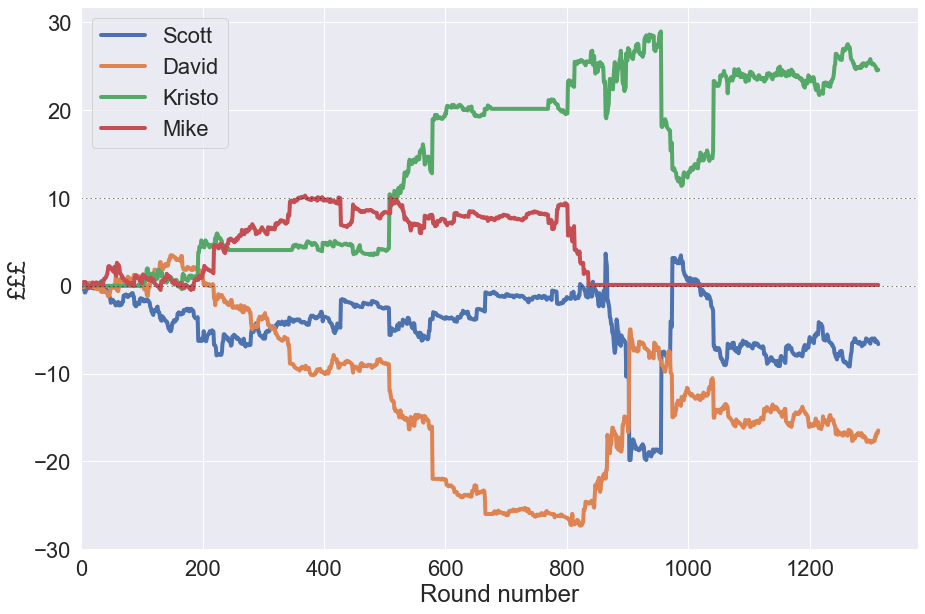

In [17]:
plot_bankroll(lifetimedf, lifetimenames, os.path.join(fig_folder, 'lifetime_bankroll.png'))

## Lifetime showdown

In [18]:
for i in range(len(dfall)):
    dfall[i] = winnings_analysis.unify_names(dfall[i], namegroups)

In [79]:
for i, dfraw_i in enumerate(dfall):
    print(f'\r{i+1}', end='')
    df_showdown = winnings_analysis.get_showdown_hands(dfraw_i, lifetimenames)
    nonname = [c for c in df_showdown.columns if c!='Name']
    if i==0:
        dfsl = df_showdown
    else:
        dfsl[nonname] = dfsl[nonname] + df_showdown[nonname]
dfsl = dfsl.reset_index(drop=1)

17

In [80]:
dfsl_perc = dfsl.copy()
dfsl_perc[nonname] = 100*np.divide(dfsl_perc[nonname].values, dfsl_perc[nonname].sum(axis=1).values.reshape(len(lifetimenames), -1))

In [81]:
dfsl = col_renamer(dfsl)
dfsl_perc = col_renamer(dfsl_perc)

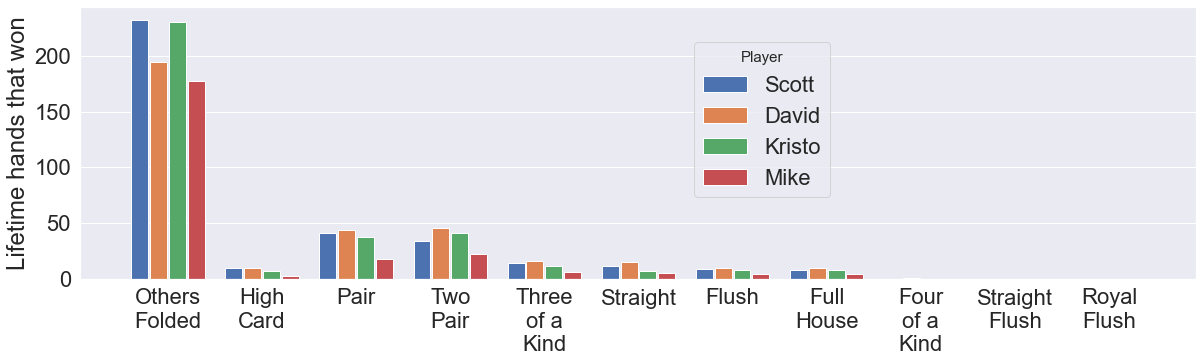

In [92]:
bar_plotter(dfsl, save=True, fig_folder=fig_folder, ylabel='Lifetime hands that won', filename='abs_lifetime_showdown.png', width=20)

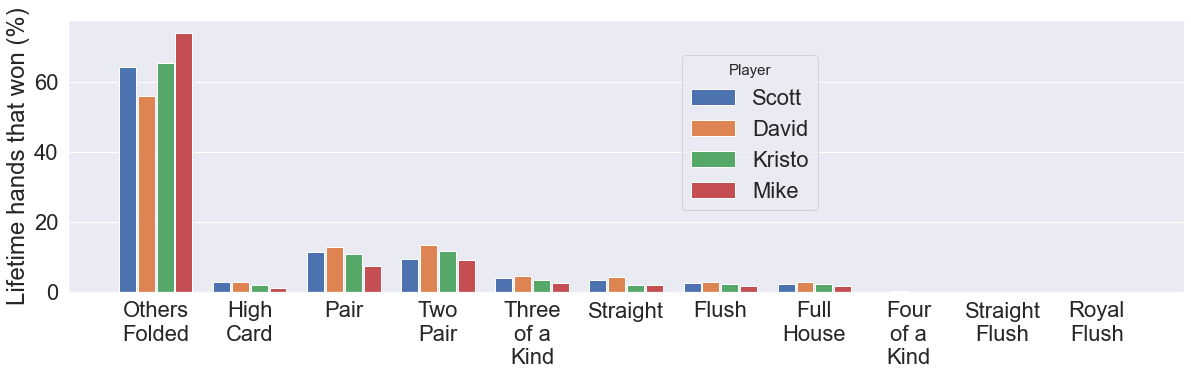

In [93]:
bar_plotter(dfsl_perc, save=True, fig_folder=fig_folder, ylabel='Lifetime hands that won (%)', filename='perc_lifetime_showdown.png', width=20)

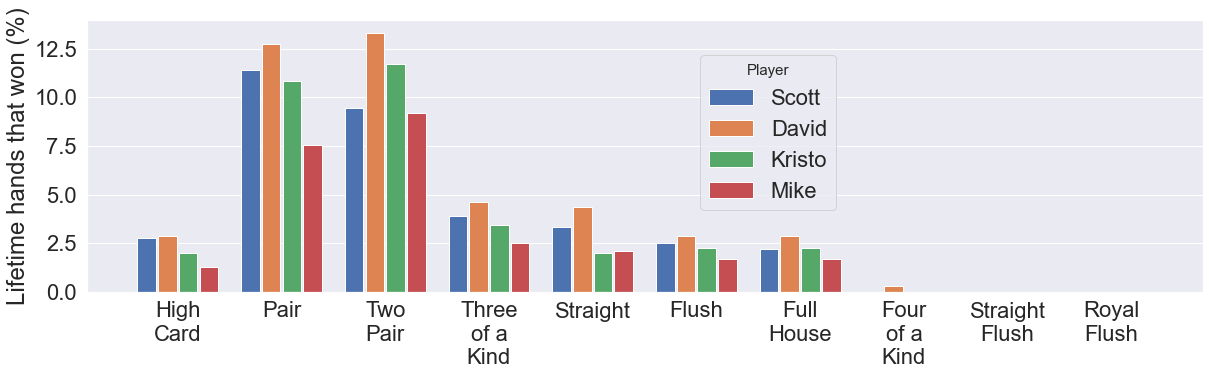

In [94]:
bar_plotter(dfsl_perc.drop(columns='Others\nFolded'),
            save=True,
            fig_folder=fig_folder,
            ylabel='Lifetime hands that won (%)',
            filename='perc_lifetime_showdown_no_fold.png', width=20)

In [97]:
dfsl_perc

,Name,Others\nFolded,High\nCard,Pair,Two\nPair,Three\nof a\nKind,Straight,Flush,Full\nHouse,Four\nof a\nKind,Straight\nFlush,Royal\nFlush
0,Scott,64.444444,2.777778,11.388889,9.444444,3.888889,3.333333,2.500000,2.222222,0.000000,0.0,0.0
1,David,56.069364,2.890173,12.716763,13.294798,4.624277,4.335260,2.890173,2.890173,0.289017,0.0,0.0
2,Kristo,65.527066,1.994302,10.826211,11.680912,3.418803,1.994302,2.279202,2.279202,0.000000,0.0,0.0
3,Mike,74.058577,1.255230,7.531381,9.205021,2.510460,2.092050,1.673640,1.673640,0.000000,0.0,0.0
